In [878]:
#40変数L96 完全モデル・完全観測での4D-ETKF
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import random


[7227.00000011 7227.05000011 7227.10000011 ... 7299.90000011 7299.95000011
 7300.00000011]


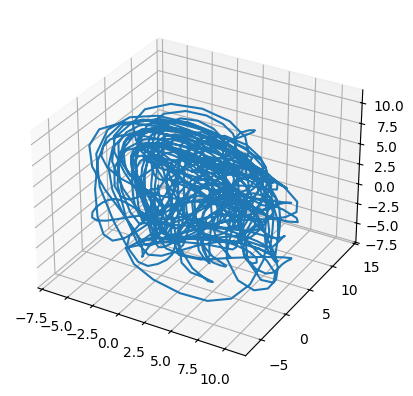

In [879]:
# Simulation parameters
t0 = 0.0 #初期時刻
dt = 1.e-2 #時間刻み幅
obs_interval = 5 #同化間隔(6hに相当するよう設定), 5なら5*dtごとに観測
n_timestep = obs_interval * 4 * 365  # 合計タイムステップ(1year)
n_data = n_timestep // obs_interval  #観測データの個数
L=4 #同化窓の長さ
n_assim = n_data//L
m = 40#8  #モデル変数の数
len_x = m #状態変数の長さ
len_obs = m #観測数
F_ex = 8.
k = 40 #アンサンブルメンバー数

#Assimilation parameters
rho=1.1

# Generate observation data by adding noise to true data
rng = np.random.default_rng(2357) #シードを固定


# Load binary data for true values
with open("1scale_t_truedata_fort_50span.bin", "rb") as f_t:
    data_time = np.frombuffer(f_t.read(), dtype=np.float64)
data_time = np.append(data_time[0] + (data_time[0] -data_time[1]), data_time)
print(data_time)


with open("1scale_xtrue_timeseries_km40_F8_50span.bin", "rb") as f_x1:
# with open("1scalePlusSin_xtrue_timeseries_km40_F8_50span.bin", "rb") as f_x1: #モデル誤差あり(動作しない)
    true_data_x = np.frombuffer(f_x1.read(), dtype=np.float64)

true_data_x = true_data_x.reshape((n_data, m))

fig = plt.figure()
ax=fig.add_subplot(111, projection='3d')
# ax.plot(true_data_x[:,k//3],true_data_x[:,k//3 *2],true_data_x[:,-1])
# ax.plot(true_data_x[:,-3],true_data_x[:,-2],true_data_x[:,-1])
ax.plot(true_data_x[:,3],true_data_x[:,2],true_data_x[:,1])


In [880]:
@njit(cache=True)
def model_forecast(t, X, F_ex):
    """
    L96モデルのdX/dtを計算する関数。

    Parameters:
        t:時刻
        X:モデル変数
        F_ex:外力

    Returns:
        model (numpy.ndarray): dX/dtの配列
    """
    mm = len(X)
    model = np.empty(mm)  # Initialize the model array
    for a in range(mm):
        model[a] =  X[(a - 1) % mm] * (X[(a + 1) % mm] - X[(a - 2) % mm]) - X[a] + F_ex
    return model


@njit(cache=True)
def RK4(t,model, y0, dt, steps, *model_args):
    """
    4次のルンゲクッタ法で微分方程式を数値積分する汎用関数。

    Parameters:
        model (function): 微分方程式モデル f(t, y, *args) を指定。
                          t (float): 現在の時間
                          y (array-like): 現在の状態ベクトル
                          *args: モデルに渡す追加の引数
        y0 (array-like): 初期状態ベクトル
        dt (float): 時間刻み幅
        steps (int): 積分するステップ数
        *model_args: モデルに渡す追加の引数（任意）

    Returns:
        # t (numpy.ndarray): 時間の配列
        y (numpy.ndarray): 時間発展後の状態ベクトル
    """
    y = y0
    t = t0

    for step in range(steps):
        k1 = dt * model(t, y, *model_args)
        k2 = dt * model(t + dt / 2, y + k1 / 2, *model_args)
        k3 = dt * model(t + dt / 2, y + k2 / 2, *model_args)
        k4 = dt * model(t + dt, y + k3, *model_args)

        y = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t = t + dt
    return  y

@njit(cache=True)
def compute_R_atr(true_data):
    """
    アトラクタ半径を数値的に求める関数。
    Parameter:
        true_data:アトラクタ半径(状態空間上)を求めたい状態変数の配列(時間数, 成分数)

    Return:
        R_atr:アトラクタ半径
    """
    n = true_data.shape[0] #時間方向に何個データあるか
    R_atr = 0.0
    for k in range(n):
        for l in range(k + 1, n):  # l_listに相当
            diff = true_data[k] - true_data[l]
            R_atr += np.sqrt(np.sum(diff ** 2))
    R_atr = R_atr * 2.0 / (n * (n - 1))
    return R_atr


# @njit(cache=True)
def ETKF(fcst, H, R, obs):
    """
    (L)ETKF(Hunt et al,2007)の解析ステップを計算する関数。
    Parameters:
        fcst:観測データ同化前の予報アンサンブル。x^b_nに相当(状態変数の成分数, アンサンブル数)
        H: 観測行列(観測数, 状態変数の成分数)
        R: 観測誤差共分散行列(観測数, 観測数)
        obs: 観測数
    """
    n_state = fcst.shape[0] #状態変数の成分数
    n_ens = fcst.shape[1] #アンサンブル数
    n_obs = H.shape[0] #観測数

    d_fcst = np.empty((n_state, n_ens)) #X^bに相当
    d_obs = np.empty((n_obs, n_ens)) #Y^bに相当

    fcst_bar = np.mean(fcst, axis=1) #x^bのアンサンブル平均

    #STEP1~2: compute X^b & Y^b
    for e in range(n_ens):
        d_fcst[:,e] = (fcst[:,e] - fcst_bar)
        d_obs[:,e] = H @ d_fcst[:,e]  #(観測数,アンサンブル数) linear observationを仮定

    #STEP3: localization

    #STEP4
    C = d_obs.T @ np.linalg.inv(R) #(観測数,アンサンブル数).T@(観測数,観測数)→(アンサンブル数,観測数)

    #STEP5
    l,U = np.linalg.eig((((n_ens-1) /rho) * np.identity(n_ens)) + C @ d_obs)
    l= np.real(l)
    U = np.real(U)
    D_1 = np.diag(l**-1.)
    Pa_tild = (U @ D_1 @ U.T)  #P~a = UD^(-1)U.T

    #STEP6
    D_2 = np.diag(np.sqrt(1./l))#ｌ^-0.5を対角成分にもつ行列D^-0.5の生成
    Wa =  U @ D_2 @U.T * (n_ens-1)**0.5   #いわゆるT(変換行列)
    d_anls = d_fcst @ Wa #X^a_nに相当

    #STEP7
    wbar_a = Pa_tild @ C @(obs- H @ fcst_bar) #(m,m)@(m,km)@(km,1) = (m,1)

    #STEP8
    e=0
    anls = np.empty_like(fcst) #x^a_nに相当
    for e in range(n_ens):
        Wa[:,e] += wbar_a
        # anls[:,e] = fcst[:,e] + d_fcst @ dWa[:,e]
        anls[:,e] = fcst_bar + d_fcst @ Wa[:,e]

    #STEP9(Localizationありの時)


    return fcst_bar, d_fcst, d_anls, anls



def FourD_ETKF(fcst_lag, H_lag, R_lag, obs_lag):
    """
    4D-ETKFの解析ステップ

    Parameters:
        fcst_lag: 予報アンサンブル（L, n_state, n_ens）: Lラグ分
        H_lag: 観測演算子のリスト（L個の観測行列）
        R_lag: 観測誤差共分散のリスト（L個）
        obs_lag: ラグ分の観測（L, n_obs）

    Returns:
        fcst_bar: 解析平均（L, n_state）
        d_fcst: 予報偏差（L, n_state, n_ens）
        d_anls: 解析偏差（L, n_state, n_ens）
        anls: 解析アンサンブル（L, n_state, n_ens）
    """
    L, n_state, n_ens = fcst_lag.shape
    n_obs_total = sum(H.shape[0] for H in H_lag)

    # アンサンブル平均と偏差

    fcst_bar = np.mean(fcst_lag, axis=2) #スムーザー, (ラグ数, 成分数)
    d_fcst = np.empty((L, n_state, n_ens)) # ラグ内の全観測時刻について更新
    d_anls = np.empty((L, n_state, n_ens))


    # Y^b: 観測空間に投影した予報偏差（結合）
    d_obs_stack = np.empty((n_obs_total, n_ens))
    obs_stack = np.empty(n_obs_total)
    idx = 0
    for l in range(L):
        Hl = H_lag[l]
        Rl = R_lag[l]
        ol = obs_lag[l]
        n_obs_l = Hl.shape[0]
        d_fcst[l] = fcst_lag[l] - np.mean(fcst_lag[l], axis=1)[:, None] #[:,None]が大事


        d_obs_l = Hl @ d_fcst[l]
        d_obs_stack[idx:idx+n_obs_l, :] = d_obs_l
        obs_stack[idx:idx+n_obs_l] = ol
        idx += n_obs_l

    # C
    R_block_inv = np.linalg.inv(np.block([
        [R_lag[i] if i == j else np.zeros_like(R_lag[i])
         for j in range(L)]
        for i in range(L)
    ]))

    C = d_obs_stack.T @ R_block_inv

    # ETKFステップ
    l, U = np.linalg.eig(((n_ens - 1) / rho) * np.identity(n_ens) + C @ d_obs_stack)
    l = np.real(l)
    U = np.real(U)

    D_1 = np.diag(1.0 / l)
    Pa_tilde = U @ D_1 @ U.T

    D_2 = np.diag(np.sqrt(1.0 / l))
    T = U @ D_2 @ U.T * np.sqrt(n_ens - 1)

    # wbar
    obs_model = np.concatenate([H_lag[l] @ fcst_bar[l] for l in range(L)]) #スムーザー

    wbar = Pa_tilde @ C @ (obs_stack - obs_model)

    # 各アンサンブル更新

    anls = np.empty_like(fcst_lag) #スムーザー
    for lag in range(L):
        d_anls[lag] = d_fcst[lag] @ T # d_anls = X^a'

        for e in range(n_ens):
            anls[lag, :, e] = fcst_bar[lag] + d_fcst[lag] @ (T[:, e] + wbar)


    return fcst_bar, d_fcst, d_anls, anls


In [881]:
# Identity matrices for H and R
H = np.identity(len_x) #完全観測(観測数＝状態変数の数)
R = np.identity(len_obs)


# Analysis and forecast data arrays
analysis_data = np.zeros((n_data+1, len_x)) #(時系列数, 成分数)
forecast_data = np.zeros((n_data+1, len_x))


In [882]:
#アトラクタ上の値から解析アンサンブルの初期値を出す
with open("1scale_x_initial_km40_F8.bin", "rb") as i_x1:
    init_data = np.frombuffer(i_x1.read(), dtype=np.float64)

n_init = 1000
init_data = init_data.reshape((n_init,m))

print('init_data', init_data.shape)

R_atr = compute_R_atr(init_data)

print('R_atr=',R_atr)
analysis = np.empty((len_x,k))
forecast = np.empty((len_x, k))


#初期ensambleの作成
init_idx = list(np.arange(0,n_init)) #解析値の初期値(t=-dt*assim_step)を選ぶ為の配列

random.seed(1234)
random.shuffle(init_idx)
print('initial indices for analyzed',init_idx[:k])
# print('initial indices for forecast',init_idx[m:2*m])


ens=0
for ens in range(k):
    random_idx_anls = init_idx[ens]
    analysis[:,ens] = init_data[random_idx_anls,:] #use climatology as initial ensamble
    # analyzed[:,ens] = obs_data[0,:] +rng.standard_normal(len_x) #use t0's data as inital ensamble
forecast = analysis #+rng.standard_normal((len_x,k))  #プロットのために便宜上設定


analysis_data[0,:] = np.mean(analysis,axis=1)
forecast_data[0, :] = np.mean(forecast,axis=1)


# Trace arrays
# Trace arrays
trace_P_a = np.zeros(n_assim)
trace_P_f = np.zeros(n_assim)
spread = np.zeros(n_assim)

P_a = np.identity(len_x) * R_atr
P_f = np.identity(len_x) * R_atr

trace_P_a[0] = np.trace(P_a)
spread[0] = R_atr
trace_P_f[0] = np.trace(P_f)


assim_time = np.zeros(n_assim+1)
assim_time[0] = data_time[1] #同化サイクルの時間経過を記録

true_data =np.empty((n_data+1, m) )
true_data[0] = init_data[-1]
true_data[1:] = true_data_x
obs_data_x = true_data+ rng.standard_normal((n_data+1, len_obs))


init_data (1000, 40)
R_atr= 31.494869003146977
initial indices for analyzed [np.int64(56), np.int64(306), np.int64(558), np.int64(770), np.int64(733), np.int64(654), np.int64(957), np.int64(566), np.int64(505), np.int64(823), np.int64(914), np.int64(963), np.int64(374), np.int64(493), np.int64(258), np.int64(325), np.int64(44), np.int64(618), np.int64(428), np.int64(314), np.int64(543), np.int64(382), np.int64(908), np.int64(11), np.int64(412), np.int64(525), np.int64(271), np.int64(297), np.int64(344), np.int64(6), np.int64(183), np.int64(323), np.int64(59), np.int64(313), np.int64(473), np.int64(184), np.int64(403), np.int64(886), np.int64(245), np.int64(335)]


In [883]:
forecast_lag = np.zeros((L, len_x, k))

for i in range(1, n_assim+1):
# for i in range(n_assim):

    # 各ラグ時刻ごとの予報（lag = 0 から L-1）

    for e in range(k):
        state = analysis[:, e].copy()
        for lag in range(L):
            t_start = assim_time[i - 1] + lag * dt * obs_interval
            steps = obs_interval
            state = RK4(t_start, model_forecast, state, dt, steps, F_ex)
            forecast_lag[lag, :, e] = state  #解析ステップでの値が尻尾




    forecast_bar, d_forecast, d_analysis, analysis_lag = FourD_ETKF(forecast_lag, H_lag=[H]*L, R_lag=[R]*L, obs_lag=obs_data_x[(i-1)*L +1 : i*L +1]) #obs_data[1]からL個ずつ同化
    analysis = analysis_lag[-1]

    # 解析時刻の予報・解析値
    forecast_data[(i-1)*L +1 : i*L +1] = np.mean(forecast_lag, axis=2)
    analysis_data[(i-1)*L +1 : i*L +1] = np.mean(analysis_lag, axis=2)


    # #RTPS
    # alpha =0.25
    # alpha_param = 1.
    # n=0.
    # for n in range(len_x):
    #     if n <m:
    #         d_analysis[-1,n,:] *= 1.- alpha + alpha * np.linalg.norm(d_forecast[-1, n,:])/np.linalg.norm(d_analysis[-1, n,:])
    #     else:
    #          d_analysis[-1, n,:] *= 1.- alpha_param + alpha_param * np.linalg.norm(d_forecast[-1, n,:])/np.linalg.norm(d_analysis[-1, n, :])
    # analysis = analysis_data[i* L][:, None] + d_analysis[-1]


    assim_time[i] = assim_time[i-1] + dt*obs_interval*L


In [884]:
1460/L

365.0

In [885]:
i*L+1

1461

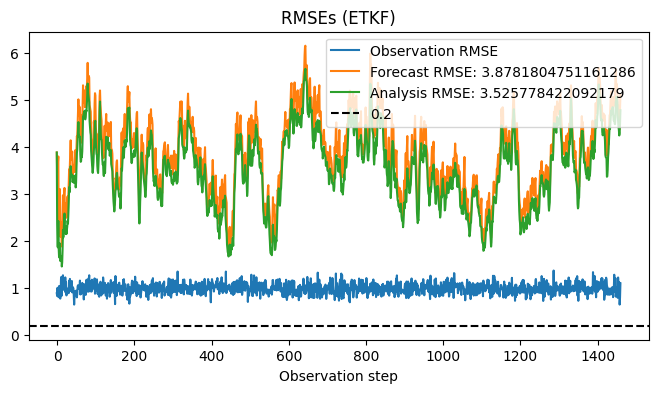

3.4205535744329034


In [886]:
# Compute RMSE
RMSE_obs_x1 = np.linalg.norm(obs_data_x[:,:m] - true_data[:,:m], axis=1) / m ** 0.5
RMSE_forecast_x1 = np.linalg.norm(forecast_data[:,:m] - true_data[:,:m], axis=1) / m ** 0.5
RMSE_analysis_x1 = np.linalg.norm(analysis_data[:,:m] - true_data[:,:m], axis=1) / m ** 0.5

# Plot results
fig1=plt.figure(figsize=(8,4))
ax1 = fig1.add_subplot(111)
ax1.plot((data_time-data_time[1])/(dt*obs_interval), RMSE_obs_x1, label="Observation RMSE")
ax1.plot((data_time-assim_time[0])/(dt*obs_interval), RMSE_forecast_x1, label="Forecast RMSE: "+str(np.mean(RMSE_forecast_x1)))
ax1.plot((data_time-assim_time[0])/(dt*obs_interval), RMSE_analysis_x1, label="Analysis RMSE: "+str(np.mean(RMSE_analysis_x1)), alpha=1.)
# ax1.plot((data_time[::len_window]-assim_time[0])/(dt*obs_interval), spread, label='Spread: '+str(np.mean(spread)))
ax1.axhline(0.2, color='k', linestyle='--', label="0.2")

ax1.set_xlabel("Observation step")
# ax1.set_ylim((-0.5,1.5))
ax1.legend()
ax1.set_title('RMSEs (ETKF)')

plt.show()
print(np.mean(RMSE_analysis_x1[:-1000]))

In [887]:
assim_time.shape

(366,)